# LQR trajectory control of 2-DoF quadruped leg 

### Model Scheme

The figure below provides a visual representation of the model and illustrates what the different parameters in the code correspond to.  
Note that in the code, the coordinate system is mirrored around the z-axis.o.

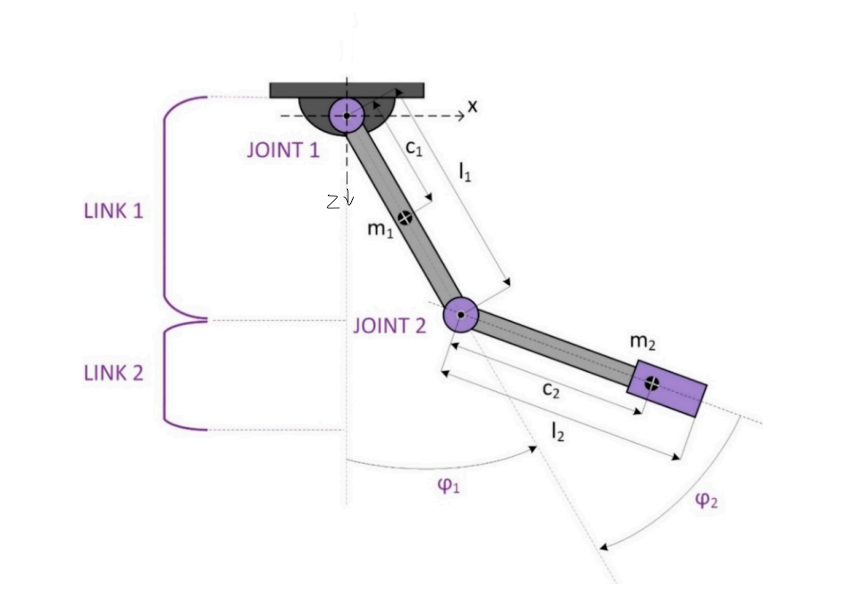

### General Information
The code is designed to run within the Jupyter Lab environment.  
It is important that the user works specifically in Jupyter Lab and not in Jupyter Notebook, as certain functionalities may not work properly in Notebook.  
All functions are thoroughly documented with comments that clearly explain their purpose, input parameters, and return values.  
This ensures that the code remains accessible, easy to understand, and maintainable for future users and developers.

The project provides a custom-designed controller to move a 2-DOF quadruped leg to a desired position.  
As a user, you can experiment with the controller parameters or modify the controller's functionalities to suit specific needs or explore different control strategies.
tegies.


### Installing the Required Python Libraries

To install the necessary libraries, run the following command **in a code cell** (select "Code" in the dropdown menu, **not Markdown**) and execute it.  
After installing, you need to **restart the kernel** for the changes to take effect.

```bash
!pip install sympy numpy scipy control matplotlib ipython
```

Alternatively, you can open the **Anaconda Prompt** (or any terminal) and run the same command there.  
Afterwards, start (or restart) Jupyter Lab.

---


**Import libraries**

In [1]:
import sympy as sp
import numpy as np
from scipy import signal
import control
import matplotlib.pyplot as plt
import math
from IPython.display import Math, display
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib import animation, rcParams
from IPython.display import HTML, display

**Define system equations: <span style="color:red">DO NOT CHANGE!</span>**


**Note**: The linearization states can be changed (line 70-75)

**Activate line numbers**: *View* > *Show Line Numbers*

In [2]:
# Define symbols
w1, w2, f1, f2, m1, m2, c1, c2, l1, g, I1, I2, Tc1, Tc2, beta1, beta2, t1, t2 = sp.symbols('w1 w2 f1 f2 m1 m2 c1 c2 l1 g I1 I2 Tc1 Tc2 beta1 beta2 t1 t2')

# Define system
M11 = m1*c1**2 + m2*c2**2 + m2*l1**2 + 2*m2*c2*l1*sp.cos(f2) + I1 + I2 
M12 = m2*c2**2 + m2*c2*l1*sp.cos(f2) + I2
M21 = m2*c2**2 + m2*c2*l1*sp.cos(f2) + I2
M22 = m2*c2**2 + I2

M = sp.Matrix([[M11,M12],
               [M21, M22]])

k = 50  # overgangsscherpte
F11 = ((2/sp.pi) * sp.atan(k * w1)) + beta1 * w1
F21 = ((2/sp.pi) * sp.atan(k * w2)) + beta2 * w2 

F = sp.Matrix([[F11],
               [F21]])

RL11 = t1 + 2*m2*c2*l1*sp.sin(f2)*w1*w2 + m2*c2*l1*sp.sin(f2)*w2**2 - m2*g*c2*sp.sin(f1+f2) - (m1*c1+m2*l1)*g*sp.sin(f1) - F11
RL21 = t2 - m2*c2*l1*sp.sin(f2)*w1**2 - m2*g*c2*sp.sin(f1+f2) - F21

RL = sp.Matrix([[RL11],
                [RL21]])

RL_non_linear = M.inv()*RL

# Equations for ODE model
eq1 = RL_non_linear[0]
eq2 = RL_non_linear[1]
eq1_np = sp.lambdify(
    [w1, w2, f1, f2, m1, m2, c1, c2, l1, g, I1, I2, Tc1, Tc2, beta1, beta2, t1, t2],
    eq1,
    "numpy")

eq2_np = sp.lambdify(
    [w1, w2, f1, f2, m1, m2, c1, c2, l1, g, I1, I2, Tc1, Tc2, beta1, beta2, t1, t2],
    eq2,
    "numpy")

# Convert system equations into right form for SS model: Add two extra rows for the extra equations
RL_ss = sp.Matrix([[eq1],
                   [eq2],
                   [w1],
                   [w2]])

# Linearize system at linearization point
states = sp.Matrix([[w1],
                    [w2],
                    [f1],
                    [f2]])

inputs = sp.Matrix([[t1],
                    [t2]])
                   
A_sp = RL_ss.jacobian(states)
B_sp = RL_ss.jacobian(inputs)

A_np = sp.lambdify(
    [w1, w2, f1, f2, m1, m2, c1, c2, l1, g, I1, I2, Tc1, Tc2, beta1, beta2, t1, t2],
    A_sp,
    "numpy")

B_np = sp.lambdify(
    [w1, w2, f1, f2, m1, m2, c1, c2, l1, g, I1, I2, Tc1, Tc2, beta1, beta2, t1, t2],
    B_sp,
    "numpy")

## Linearisation parameters: Can be changed ------------------------------------------------------------------------------------------------------------------------------------------------------------------
w1_l = 0 # rad/s  
w2_l = 0 # rad/s  
f1_l = 0 # rad    
f2_l = 0 # rad    
t1_l = 0 # Nm     
t2_l = 0 # Nm 
## ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Enter fixed parameters
m1_val = 0.350           # kg
m2_val = 0.1             # kg
l1_val = 0.170           # m
c1_val = 0.054           # m
c2_val = 0.08            # m
I1_val = 3.925e-3        # kgm²
I2_val = 1.613e-3        # kgm²
g_val = 9.81             # m/s²
Tc1_val = 0.42          # Nm
Tc2_val = 0.659         # Nm
beta1_val = 0.008      # Nms/rad
beta2_val = 0.005       # Nms/rad

display(Math(r'\omega_{1,linearization point} = ' + sp.latex(w1_l) + r'rad/s'))
display(Math(r'\omega_{2,linearization point} = ' + sp.latex(w2_l) + r'rad/s'))
display(Math(r'\varphi_{1,linearization point} = ' + sp.latex(f1_l) + r'rad'))
display(Math(r'\varphi_{2,linearization point} = ' + sp.latex(f2_l) + r'rad'))
display(Math(r'\tau_{1,linearization point} = ' + sp.latex(t1_l) + r'Nm'))
display(Math(r'\tau_{2,linearization point} = ' + sp.latex(t2_l) + r'Nm'))

# Enter values and define SS sytem
A = A_np(w1_l, w2_l, f1_l, f2_l, m1_val, m2_val, c1_val, c2_val, l1_val, g_val, I1_val, I2_val, Tc1_val, Tc2_val, beta1_val, beta2_val, t1_l, t2_l)
B = B_np(w1_l, w2_l, f1_l, f2_l, m1_val, m2_val, c1_val, c2_val, l1_val, g_val, I1_val, I2_val, Tc1_val, Tc2_val, beta1_val, beta2_val, t1_l, t2_l)

C = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
D = [[0,0],[0,0],[0,0],[0,0]]
C = np.array(C, dtype=float)
D = np.array(D, dtype=float)

sys = signal.StateSpace(A, B, C, D)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**ODE model**: The system equations are called *eq1_np* & *eq2_np*

**SS model**: The system is defined as *"sys"* with *A*, *B*, *C* & *D* matrices

**Define the initial conditions**

In [3]:
## Only change first 4 values-----------------------------------------------------------------------------------------------------------------
f1_0 = 0      # rad
f2_0 = 0       # rad
w1_0 = 0       # rad/s
w2_0 = 0       # rad/s
##-----------------------------------------------------------------------------------------------------------------------------------------------

initial_state = np.array([w1_0, w2_0, f1_0, f2_0])

display(Math(r'\omega_{1,0} = ' + sp.latex(w1_0) + r'rad/s'))
display(Math(r'\omega_{2,0} = ' + sp.latex(w2_0) + r'rad/s'))
display(Math(r'\varphi_{1,0} = ' + sp.latex(f1_0) + r'rad'))
display(Math(r'\varphi_{2,0} = ' + sp.latex(f2_0) + r'rad'))

px_0 = l1_val * sp.sin(f1_0) + l1_val *sp.sin(f1_0 + f2_0)
pz_0 = -(l1_val * sp.cos(f1_0) + l1_val * sp.cos(f1_0 + f2_0))

t2_static = c2_val*sp.sin(f1_0+f2_0)*m2_val*g_val - Tc2_val 
t1_static = c1_val*sp.sin(f1_0)*m1_val*g_val + (l1_val*sp.sin(f1_0)+c2_val*sp.sin(f1_0+f2_0))*m2_val*g_val - t2_static - Tc1_val
t2_static = np.float64(t2_static)
t1_static = np.float64(t1_static)
initial_torque = np.array([t1_static,t2_static])

display(Math(r'Starting\ position:'))
display(Math(r'p_{x,0} = ' + sp.latex(px_0*1000) + r'mm'))
display(Math(r'p_{z,0} = ' + sp.latex(pz_0*1000) + r'mm'))

px_0 = -np.float64(px_0)*1000
pz_0 = -np.float64(pz_0)*1000

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Functions needed to generate a desired trajectory: <span style="color:red">DO NOT CHANGE!</span>**

In [4]:
import numpy as np
import math

def generate_trajectory(x_start, z_start, x_end, z_end,
                        spacing=1, trajectory_type='linear'):
    """
    Generate points spaced approximately `spacing` mm apart along a segment.
    Supports 'linear', 'parabolic', and 'circular' trajectories.

    Parameters:
      x_start, z_start : start coordinates in mm
      x_end,   z_end   : end coordinates in mm
      spacing          : desired step size in mm
      trajectory_type  : 'linear', 'parabolic', or 'circular'
    """
    # Mirror coordinates as in original code (if desired)
    x_start, z_start = -x_start, -z_start
    x_end,   z_end   = -x_end,   -z_end

    if trajectory_type == 'linear':
        # Straight line
        dx, dz = x_end - x_start, z_end - z_start
        length = math.hypot(dx, dz)
        n = max(int(round(length / spacing)), 1)
        px = np.linspace(x_start, x_end, n + 1)
        pz = np.linspace(z_start, z_end, n + 1)

    elif trajectory_type == 'parabolic':
        # Approximate arc length using coarse sampling
        t_coarse = np.linspace(0, 1, 500)
        mid_z = (z_start + z_end) / 2 + 0.2 * abs((z_end - z_start) + (x_end - x_start))
        x_coarse = (1 - t_coarse) * x_start + t_coarse * x_end
        z_coarse = (1 - t_coarse)**2 * z_start \
                   + 2 * (1 - t_coarse) * t_coarse * mid_z \
                   + t_coarse**2 * z_end
        deltas = np.hypot(np.diff(x_coarse), np.diff(z_coarse))
        length = deltas.sum()
        n = max(int(round(length / spacing)), 1)

        # Final parametric points
        t = np.linspace(0, 1, n + 1)
        px = (1 - t) * x_start + t * x_end
        pz = (1 - t)**2 * z_start \
             + 2 * (1 - t) * t * mid_z \
             + t**2 * z_end

    elif trajectory_type == 'circular':
        # Half circle (start and end diametrically opposed)
        cx = (x_start + x_end) / 2
        cz = (z_start + z_end) / 2
        radius = math.hypot(x_start - cx, z_start - cz)
        ang0 = math.atan2(z_start - cz, x_start - cx)
        ang1 = math.atan2(z_end - cz, x_end - cx)
        if ang1 > ang0:
            ang1 -= 2 * math.pi
        arc_len = radius * abs(ang1 - ang0)
        n = max(int(round(arc_len / spacing)), 1)
        theta = np.linspace(ang0, ang1, n + 1)
        px = cx + radius * np.cos(theta)
        pz = cz + radius * np.sin(theta)

    else:
        raise ValueError("trajectory_type must be 'linear', 'parabolic', or 'circular'.")

    # Drop the last point to avoid duplication between segments
    return px[:-1].tolist(), pz[:-1].tolist()


def combine_trajectories(segments, spacing=1):
    full_px, full_pz = [], []

    for seg in segments:
        xs, zs = generate_trajectory(
            seg['start'][0], seg['start'][1],
            seg['end'][0],   seg['end'][1],
            spacing,
            seg['type']
        )
        full_px.extend(xs)
        full_pz.extend(zs)

    # Mirror the final endpoint
    x_end, z_end = segments[-1]['end']
    full_px.append(-x_end)
    full_pz.append(-z_end)

    return full_px, full_pz


**Specify your own desired trajectory**

**Note**: The coordinate system used for the leg is inverted compared to the conventional Cartesian frame. This becomes apparent when you run the next cell and observe the orientation of the axes in the workspace plot.

In [5]:
# Example trajectory specification
'''
segments = [
    {'start': (0, 340), 'end': (0, 140), 'type': 'parabolic'},
    {'start': (0, 140), 'end': (-40, 140), 'type': 'linear'},
    {'start': (-40, 140), 'end': (0, 240), 'type': 'circular'},
]
'''

segments = [
    {'start': (px_0, pz_0), 'end': (100, 240), 'type': 'parabolic'},
]

px_desired_list, pz_desired_list = combine_trajectories(segments)
n = len(px_desired_list)

**Plot the trajectory in the workspace: <span style="color:red">DO NOT CHANGE!</span>**

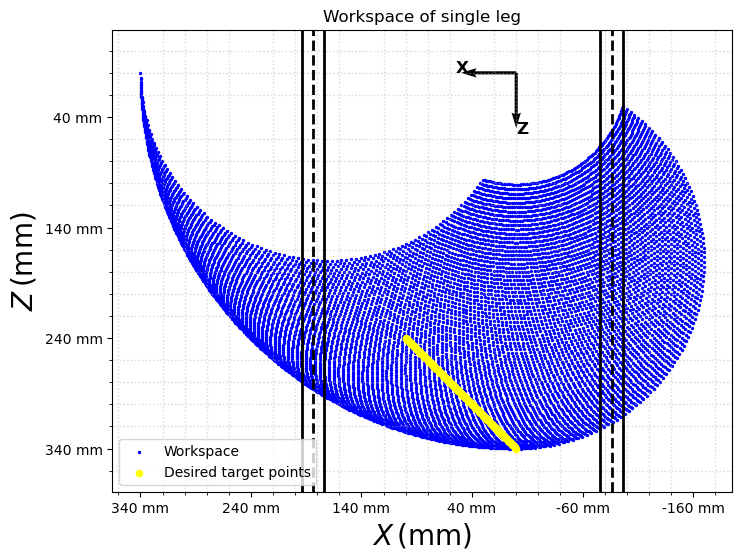

In [6]:
def calculate_workspace(L1, L2, theta1_min, theta1_max, theta2_min, theta2_max, num_points=100):
    """
    Computes the reachable workspace for a two-link planar robot leg based on given joint angle ranges.

    Parameters:
        L1, L2: Lengths of the two leg segments (in mm)
        theta1_min, theta1_max: Min and max angles for joint 1 (in radians)
        theta2_min, theta2_max: Min and max angles for joint 2 (in radians)
        num_points: Resolution for angle sampling

    Returns:
        X, Z: Arrays of reachable X and Z positions (in mm)
    """
    theta1_vals = np.linspace(theta1_min, theta1_max, num_points)
    theta2_vals = np.linspace(theta2_min, theta2_max, num_points)

    X, Z = [], []
    for theta1 in theta1_vals:
        for theta2 in theta2_vals:
            x = - (L1 * np.cos(theta1) + L2 * np.cos(theta1 + theta2))
            z = - (L1 * np.sin(theta1) + L2 * np.sin(theta1 + theta2))

            if not np.isreal(x) or not np.isreal(z):
                raise ValueError(f'Values out of workspace bounds: x = {x:.2f}, z = {z:.2f}')

            X.append(x)
            Z.append(z)

    return np.array(X), np.array(Z)


def plot_workspace(L1, L2, X, Z):
    """
    Plots the full reachable workspace and frame references for a two-link robot leg.

    Parameters:
        L1, L2: Lengths of the leg segments (in mm)
        X, Z: Lists or arrays of reachable x and z positions (in mm)
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(X, Z, s=2, color='b', label='Workspace')

    # Plot coordinate axes
    plt.quiver(0, 0, -50, 0, color='k', scale=1, scale_units='xy', angles='xy', width=0.005)
    plt.quiver(0, 0, 0, -50, color='k', scale=1, scale_units='xy', angles='xy', width=0.005)
    plt.text(-55, 0, 'X', fontsize=12, fontweight='bold')
    plt.text(0, -55, 'Z', fontsize=12, fontweight='bold')

    # Frame lines (frame width illustration)
    for x_pos in [86.25, -183.75]:
        plt.axvline(x=x_pos, linestyle='--', color='black', linewidth=2)
        plt.axvline(x=x_pos + 10, color='black', linewidth=2)
        plt.axvline(x=x_pos - 10, color='black', linewidth=2)

    # Axes and grid
    plt.xlabel(r'$X\,(\mathrm{mm})$', fontsize=20)
    plt.ylabel(r'$Z\,(\mathrm{mm})$', fontsize=20)
    plt.title('Workspace of single leg')
    plt.axis('equal')
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', linewidth=1, alpha=0.5)

    # Custom ticks and labels
    xticks = np.arange(min(X), max(X), step=100)
    yticks = np.arange(min(Z), max(Z), step=100)
    plt.xticks(xticks, labels=[f'{int(-val)} mm' for val in xticks])
    plt.yticks(yticks, labels=[f'{int(-val)} mm' for val in yticks])


def plot_desired_points_on_workspace(px_desired_list, pz_desired_list):
    """
    Overlays the desired trajectory points on the workspace plot.

    Parameters:
        px_desired_list: List or array of x coordinates in mm
        pz_desired_list: List or array of z coordinates in mm
    """
    plt.scatter(px_desired_list, pz_desired_list, color='yellow', s=20, zorder=5, label='Desired target points')
    plt.legend()


def main():
    """
    Main routine to compute the workspace, plot it, and overlay a desired trajectory.
    """
    L1, L2 = 170, 170
    theta1_min, theta1_max = 0, np.pi/2
    theta2_min, theta2_max = (180-34.6) * np.pi / 180, 0  # π - π = 0

    # Calculate reachable workspace
    X, Z = calculate_workspace(L1, L2, theta1_min, theta1_max, theta2_min, theta2_max)

    # Plot workspace and desired points
    plot_workspace(L1, L2, X, Z)
    
    # Example desired points (in mm) — make sure these variables are defined before calling main
    plot_desired_points_on_workspace(px_desired_list, pz_desired_list)
    
    # Save figure to file
    plt.savefig(r"C:\Users\vikto\OneDrive\Documenten\Industriële ingenieurswetenschappen\Master\Thesis\Figures\TrajectoryExample.png", dpi=300, bbox_inches='tight')
    plt.show()


if __name__ == '__main__':
    main()


**Functions to implement the LQR controller: <span style="color:red">DO NOT CHANGE!</span>**

In [7]:
# System parameters
m = [m1_val, m2_val]
l = l1_val
c = [c1_val, c2_val]
I = [I1_val, I2_val]
g = g_val
Tc = [Tc1_val, Tc2_val]
beta = [beta1_val, beta2_val]



def compute_desired_joint_angles(px_list_mm, pz_list_mm, l1_val):
    """
    Converts desired end-effector positions (mm) into joint angles for a 2-link planar leg.

    Returns lists of angles [f1_list, f2_list] in radians.
    """
    px = np.array(px_list_mm)/1000.0
    pz = np.array(pz_list_mm)/1000.0
    f1_list, f2_list = [], []
    for xi, zi in zip(px, pz):
        alpha = np.arctan2(xi, zi)
        beta = np.arccos(np.clip(np.hypot(xi, zi)/(2*l1_val), -1.0, 1.0))
        theta1 = np.pi/2 - alpha - beta
        theta2 = np.pi - 2*beta
        f1 = np.arctan2(np.sin(theta1+np.pi/2), np.cos(theta1+np.pi/2))
        f2 = np.arctan2(np.sin(-(theta2-np.pi)), np.cos(-(theta2-np.pi)))
        f1_list.append(f1)
        f2_list.append(f2)
    return f1_list, f2_list


def compute_position_error(x, x_desired, l1_val, unit='m'):
    """
    Computes the Euclidean distance between current and desired end-effector positions.

    Parameters:
        x (array): State vector [w1, w2, f1, f2]
        x_desired (list): Desired state [0, 0, f1_d, f2_d]
        l1_val (float): Leg segment length in meters
        unit (str): 'm' for meters or 'mm' for millimeters

    Returns:
        float: Position error in specified unit
    """
    # extract joint angles
    f1, f2 = x[2], x[3]
    f1_d, f2_d = x_desired[2], x_desired[3]
    # forward kinematics
    px = l1_val * np.sin(f1) + l1_val * np.sin(f1 + f2)
    pz = -(l1_val * np.cos(f1) + l1_val * np.cos(f1 + f2))
    px_d = l1_val * np.sin(f1_d) + l1_val * np.sin(f1_d + f2_d)
    pz_d = -(l1_val * np.cos(f1_d) + l1_val * np.cos(f1_d + f2_d))
    err = np.hypot(px - px_d, pz - pz_d)
    return err * 1000 if unit == 'mm' else err


def make_stop_event(x_desired, stop_threshold_mm, l1_val):
    """
    Factory for an event function that stops integration when the position error
    falls below stop_threshold_mm.

    Parameters:
        x_desired (list): Desired state [0,0,f1_d,f2_d]
        stop_threshold_mm (float): Threshold in millimeters
        l1_val (float): Leg segment length in meters

    Returns:
        function: event(t, x) -> error(m) - threshold(m)
    """
    thresh_m = stop_threshold_mm / 1000.0
    def event(t, x):
        err = compute_position_error(x, x_desired, l1_val, unit='m')
        return err - thresh_m
    event.terminal = True
    event.direction = 0
    return event


def lqr_system_dynamics(t, x, m, l, c, I, Tc, beta, g, x_desired, K):

    """
    Compute state derivatives for a 2-DOF LQR-controlled manipulator.

    Uses current state, physical params, desired state, and LQR gain to
    return [dω1, dω2, df1, df2].
    """
    # state error
    delta = x - x_desired
    # control law u = -K delta
    u = -10*K.dot(delta)
    u = np.clip(u, -20, 20)
    # unpack physical parameters
    w1, w2, f1, f2 = x
    t1, t2 = u
    m1, m2 = m; c1, c2 = c; I1, I2 = I; Tc1, Tc2 = Tc; b1, b2 = beta
    # dynamics
    df1 = w1
    df2 = w2
    dw1 = float(np.array(eq1_np(w1, w2, f1, f2,
        m1, m2, l, c1, c2, I1, I2, g, Tc1, Tc2, b1, b2, t1, t2), dtype=float).item())
    dw2 = float(np.array(eq2_np(w1, w2, f1, f2,
        m1, m2, l, c1, c2, I1, I2, g, Tc1, Tc2, b1, b2, t1, t2), dtype=float).item())
    return [dw1, dw2, df1, df2]

**Enter the control parameters**

In [8]:
# LQR parameters: First number is for joint 1, second number is for joint 2
Q = np.diag([10, 10, 200, 200])  # state weighting (w1 w2 f1 f2)
R = np.diag([1, 1])              # control weighting (t1 t2)

# Stopping threshold: If the end-effector is within a distance smaller than 'stop_threshold' 
# from the target position, the controller will proceed to the next target.
stop_threshold = 5  # m

# Maximum simulation time per target, if this is exceeded,
# the controller will start controlling automatically to the next target
max_step_time = 4     # sec

**Run the simulation: <span style="color:red">DO NOT CHANGE!</span>**

In [9]:
def run_lqr_simulation(px_desired_list, pz_desired_list, l1_val,
                       m, l, c, I, Tc, beta, g,
                       initial_state, initial_torque, stop_threshold_mm, max_step_time,
                       A, B, Q, R):
    """
    Simulates a 2-DOF quadruped leg following a series of desired targets using LQR control.

    Args:
        px_desired_list (list or ndarray): List of desired x-positions for the end-effector (in meters).
        pz_desired_list (list or ndarray): List of desired z-positions for the end-effector (in meters).
        l1_val (float): Length of the first leg segment (in meters).
        m, l, c, I, Tc, beta, g: Physical parameters of the system.
        initial_state (ndarray): Initial state vector.
        initial_torque (list or ndarray): Initial torque vector.
        stop_threshold_mm (float): Threshold distance (in mm) to consider a target reached.
        max_step_time (float): Maximum allowed simulation time per target (in seconds).
        A, B (ndarrays): State-space system matrices for linearized model.
        Q, R (ndarrays): LQR weighting matrices.

    Returns:
        t_full (ndarray): Time vector containing all timestamps of the simulation.
        x_full (ndarray): State history; array of state vectors over time.
        u_full (ndarray): Control input history; array of torque vectors applied over time.

    Notes:
        - The function switches to the next target once the current end-effector position 
          is within the specified stop threshold.
        - Torques are clipped between -2 and 2 Nm for safety.
    """
    # 1) Gain
    K, _, _ = control.lqr(A, B, Q, R)

    # 2) Desired joint angles
    f1_list, f2_list = compute_desired_joint_angles(px_desired_list,
                                                    pz_desired_list,
                                                    l1_val)
    n_targets = len(f1_list)

    # 3) Initialize logs
    initial_torque = np.asarray(initial_torque).reshape(2,)
    t_full = [0.0]
    x_full = [initial_state.copy()]
    u_full = [initial_torque.copy()]
    t0 = 0.0
    x0 = initial_state.copy()
    dt_print = 0.2

    for i, (f1_d, f2_d) in enumerate(zip(f1_list, f2_list), start=1):
        print(f"Starting target {i}/{n_targets}")
        x_des = np.array([0, 0, f1_d, f2_d])

        # skip if already within tolerance
        if compute_position_error(x0, x_des, l1_val, unit='m') <= stop_threshold_mm/1000:
            print(f"✅ Target {i} within {stop_threshold_mm} mm already")
            continue

        # stopping event
        event_fn = make_stop_event(x_des, stop_threshold_mm, l1_val)

        # dynamics: use initial_torque only at t==t0
        def dynamics(t, x):
            if abs(t - t0) < 1e-12:
                u = initial_torque
            else:
                u = -K.dot(x - x_des)*10
            u = np.clip(u, -20, 20)
            return lqr_system_dynamics(t, x,
                                       m, l, c, I, Tc, beta, g,
                                       x_des, K)

        sol = solve_ivp(dynamics,
                        [t0, t0 + max_step_time],
                        x0,
                        events=[event_fn],
                        max_step=1/8000, rtol=1e-6, atol=1e-8)

        # decide whether to skip the first sample
        start_idx = 1 if i < n_targets else 0

        # append the rest of this segment
        last_print = t0
        for t_val, x_val in zip(sol.t[start_idx:], sol.y.T[start_idx:]):
            # compute control
            if abs(t_val - t0) < 1e-12:
                u_val = initial_torque
            else:
                u_val = np.clip(-K.dot(x_val - x_des), -2, 2)

            t_full.append(t_val)
            x_full.append(x_val)
            u_full.append(u_val)

            # optional status print
            if t_val - last_print >= dt_print:
                err_mm = compute_position_error(x_val, x_des, l1_val, unit='mm')
                if err_mm > stop_threshold_mm:
                    print(f"[Target {i}] t={t_val:.2f}s err={err_mm:.1f} mm")
                last_print = t_val

        # prepare next target
        t0 = sol.t[-1]
        x0 = sol.y[:, -1]
        print(f"✅ Reached target {i}/{n_targets}")

    return np.array(t_full), np.array(x_full), np.array(u_full)/10




t_results, x_results, u_results = run_lqr_simulation(px_desired_list, pz_desired_list, l1_val,
                       m, l, c, I, Tc, beta, g,
                       initial_state, initial_torque, stop_threshold, max_step_time,
                       A, B, Q, R)

Starting target 1/142
✅ Target 1 within 5 mm already
Starting target 2/142
✅ Target 2 within 5 mm already
Starting target 3/142
✅ Target 3 within 5 mm already
Starting target 4/142
✅ Target 4 within 5 mm already
Starting target 5/142
✅ Target 5 within 5 mm already
Starting target 6/142
✅ Reached target 6/142
Starting target 7/142
✅ Reached target 7/142
Starting target 8/142
✅ Reached target 8/142
Starting target 9/142
[Target 9] t=0.20s err=36.1 mm
[Target 9] t=0.40s err=21.5 mm
✅ Reached target 9/142
Starting target 10/142
✅ Target 10 within 5 mm already
Starting target 11/142
✅ Target 11 within 5 mm already
Starting target 12/142
✅ Target 12 within 5 mm already
Starting target 13/142
✅ Target 13 within 5 mm already
Starting target 14/142
✅ Target 14 within 5 mm already
Starting target 15/142
✅ Target 15 within 5 mm already
Starting target 16/142
✅ Reached target 16/142
Starting target 17/142
✅ Reached target 17/142
Starting target 18/142
✅ Target 18 within 5 mm already
Starting targe

**Plot the results of the simulation: <span style="color:red">DO NOT CHANGE!</span>**

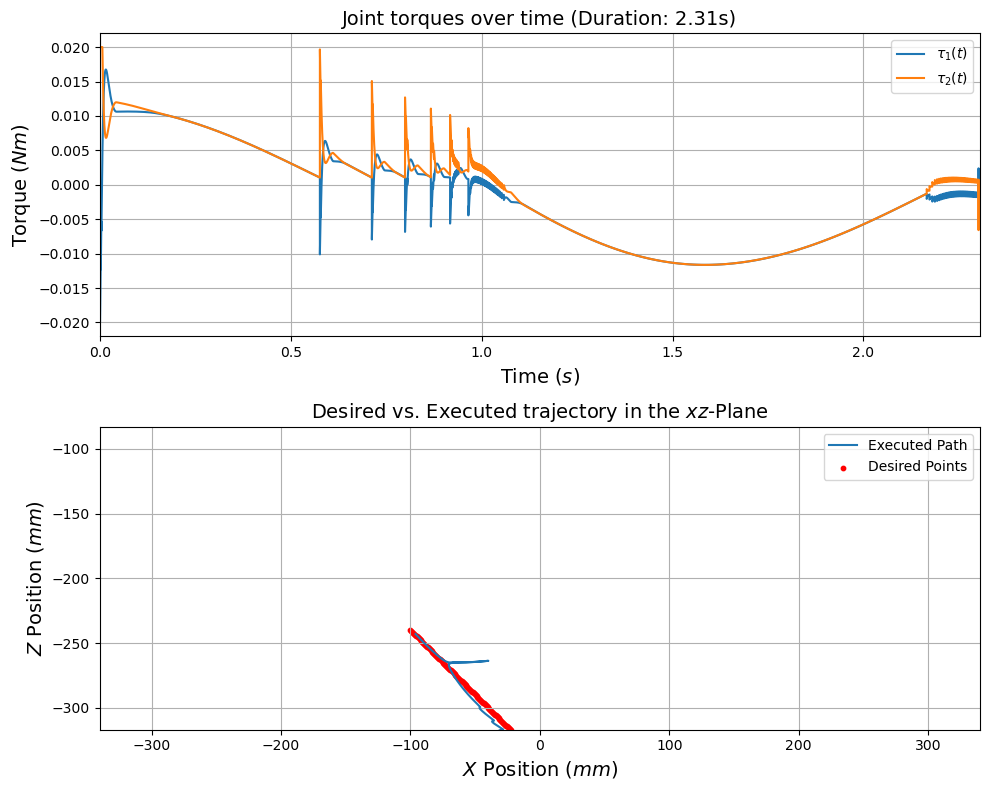

In [10]:
def plot_simulation_results(t_full, u_full, x_full, px_desired_list, pz_desired_list, l1_val, save_path="SimulationResults.png"):
    """
    Generates a single figure with two subplots:
    1) Joint torques over time
    2) XZ trajectory: desired vs. executed path

    Parameters:
        t_full (array): Time vector
        u_full (array): Control inputs [t1, t2] over time
        x_full (array): State history [w1, w2, f1, f2]
        px_desired_list, pz_desired_list (lists): Desired end-effector positions in mm
        l1_val (float): Leg segment length in meters
        save_path (str): Path to save the combined figure
    """

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))  # 2 subplots boven elkaar

    # Plot torques
    ax1.plot(t_full, u_full[:, 0]/10, label=r'$\tau_1(t)$')
    ax1.plot(t_full, u_full[:, 1]/10, label=r'$\tau_2(t)$')
    ax1.set_xlabel('Time $(s)$', fontsize=14)
    ax1.set_ylabel('Torque $(Nm)$', fontsize=14)
    ax1.set_title(rf'Joint torques over time (Duration: {t_full[-1]:.2f}s)', fontsize=14)
    ax1.legend()
    ax1.grid(True)
    ax1.set_xlim(min(t_full), max(t_full))

    # Compute executed trajectory in mm
    f1_traj = x_full[:, 2]
    f2_traj = x_full[:, 3]
    px_traj = (l1_val * np.sin(f1_traj) + l1_val * np.sin(f1_traj + f2_traj)) * 1000
    pz_traj = -(l1_val * np.cos(f1_traj) + l1_val * np.cos(f1_traj + f2_traj)) * 1000

    # Plot trajectories
    ax2.plot(px_traj, pz_traj, '-', label='Executed Path')
    ax2.scatter(px_desired_list, pz_desired_list, color='red', marker='o', s=10, label='Desired Points')
    ax2.set_xlabel(r'$X$ Position $(mm)$', fontsize=14)
    ax2.set_ylabel(r'$Z$ Position $(mm)$', fontsize=14)
    ax2.set_title(r'Desired vs. Executed trajectory in the $xz$-Plane', fontsize=14)
    ax2.axis('equal')
    ax2.set_xlim(-340, 340)
    ax2.set_ylim(-400, 0)
    ax2.legend()
    ax2.grid(True) 

    plt.tight_layout()
    plt.savefig(r"C:\Users\vikto\OneDrive\Documenten\Industriële ingenieurswetenschappen\Master\Thesis\Figures\SimulationResults.png", dpi=300)  # Save figure
    plt.show()
    
plot_simulation_results(t_results, u_results, x_results, px_desired_list, pz_desired_list, l1_val)


**View animation of the result: <span style="color:red">DO NOT CHANGE!</span>**

The animation is sped up to shorten runtime; in real time, it would run significantly slower.

In [ ]:
def animate_trajectory(t_full, u_full, x_full, px_desired_list, pz_desired_list, l1_val, fps=None):
    """
    Displays side-by-side animations:
    - Left:  2-link leg movement in the XZ plane
    - Right: Joint torques evolution in real time

    Parameters:
        t_full (array):       Time vector
        u_full (array):       Control inputs [t1, t2] over time
        x_full (array):       State history [w1, w2, f1, f2]
        px_desired_list:      Desired X positions (mm)
        pz_desired_list:      Desired Z positions (mm)
        l1_val (float):       Leg segment length (m)
        fps (int, optional):  Desired frames per second. If None, computed.
    """
    # allow larger embed size
    rcParams['animation.embed_limit'] = 50

    # Precompute positions and torques
    f1_t = x_full[:,2]
    f2_t = x_full[:,3]
    x1_t = l1_val * np.sin(f1_t)
    z1_t = -l1_val * np.cos(f1_t)
    x2_t = x1_t + l1_val * np.sin(f1_t + f2_t)
    z2_t = z1_t - l1_val * np.cos(f1_t + f2_t)
    tau1 = u_full[:,0]
    tau2 = u_full[:,1]

    # Setup figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Trajectory subplot
    ax1.set_xlim(-0.340, 0.340)
    ax1.set_ylim(-0.340, 0.340)
    ax1.set_xlabel('$X$ (m)')
    ax1.set_ylabel('$Z$ (m)')
    ax1.set_title(r'Trajectory in $XZ$-Plane')
    ax1.scatter(np.array(px_desired_list)/1000,
                np.array(pz_desired_list)/1000,
                color='blue', marker='o', s=5, label='Target')
    leg_upper, = ax1.plot([], [], 'o-', lw=3, color='orange', label='Quadruped leg')
    leg_lower, = ax1.plot([], [], 'o-', lw=3, color='orange')
    path_line,  = ax1.plot([], [], '--', lw=1, color='orange', label='Executed Path')
    ax1.legend()

    # Torque subplot
    ax2.set_xlim(0, t_full[-1])
    ymin = min(tau1.min(), tau2.min()) * 1.1
    ymax = max(tau1.max(), tau2.max()) * 1.1
    ax2.set_ylim(ymin, ymax)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Torque (Nm)')
    ax2.set_title(r'Joint Torques Over Time')
    tau_line1, = ax2.plot([], [], '-', lw=2, label=r'$\tau_1(t)$')
    tau_line2, = ax2.plot([], [], '-', lw=2, label=r'$\tau_2(t)$')
    ax2.legend()

    def init():
        leg_upper.set_data([], [])
        leg_lower.set_data([], [])
        path_line.set_data([], [])
        tau_line1.set_data([], [])
        tau_line2.set_data([], [])
        return leg_upper, leg_lower, path_line, tau_line1, tau_line2

    def update(idx):
        # Leg kinematics
        leg_upper.set_data([0, x1_t[idx]], [0, z1_t[idx]])
        leg_lower.set_data([x1_t[idx], x2_t[idx]],
                           [z1_t[idx], z2_t[idx]])
        path_line.set_data(x2_t[:idx+1], z2_t[:idx+1])

        # Torque over time
        tau_line1.set_data(t_full[:idx+1], tau1[:idx+1])
        tau_line2.set_data(t_full[:idx+1], tau2[:idx+1])
        return leg_upper, leg_lower, path_line, tau_line1, tau_line2

    # Compute frame interval and decimation
    delta_t = t_full[1] - t_full[0] if len(t_full) > 1 else 0.033
    interval = 1000 * delta_t  # ms per frame
    n_frames = len(t_full)
    # target ~200 frames total
    step = max(1, int(n_frames / 200))

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=range(0, n_frames, step),
        init_func=init,
        blit=True,
        interval=interval * step
    )

    display(HTML(ani.to_jshtml()))
    plt.close(fig)

animate_trajectory(t_results, u_results, x_results, px_desired_list, pz_desired_list, l1_val)
